In [1]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt

curr_directory = os.getcwd()

# Player Roster Information (Copied over from player_roster.ipynb)
teams = ['BOS','BRK','NYK','PHI','TOR','CHI','CLE','DET','IND','MIL','ATL','CHO','MIA','ORL','WAS',
         'DEN','MIN','OKC','POR','UTA','GSW','LAC','LAL','PHO','SAC','DAL','HOU','MEM','NOP','SAS']
        
# Dictionary of roster
# Ex. The roster of Boston Celtics players for the 2019-2020 season can be accessed using roster['BOS']['2019']
# It does not include any players/rookies for which there is no season data
roster = {}
    
for team in teams: 
    roster[team] = {}

# Initialize set for list of all players (with no repeats)
all_players = set()
    
for filename in os.listdir(os.path.join(curr_directory, 'data_sets/player_roster')):
    data = pd.read_csv(os.path.join('data_sets/player_roster', filename))
    year = filename[0:4]
    
    for team in teams:
        roster[team][year] = []
        
        players = data.loc[data['Tm'] == team]
        for ind in players.index: 
            player_name = players['Player'][ind].split('\\', 1)[0]
            if player_name not in roster[team][year]: 
                roster[team][year].append(player_name)
            
        all_players.update(roster[team][year])

num_players = len(all_players)
        
# Player dictionary that maps all players to index
player_index = dict(zip(list(all_players), range(len(all_players))))

In [2]:
game_data = pd.read_csv(os.path.join(curr_directory,'data_sets/nba.games.stats.csv'))

# Sort all values by the Date
game_data = game_data.sort_values(by=['Date'])

In [3]:
game_results = np.array(list(game_data['TeamPoints'] - game_data['OpponentPoints']))
teams = np.array(list(zip(game_data.Team, game_data.Opponent)))
dates = np.array(list(game_data['Date']))

In [4]:
unique_dates = list(set(dates))

repeat_indexes = []

for date in unique_dates: 
    same_day = np.where(dates == date)
    # suppose same_day = [0, 1, 2, 3, 4, 5]
    for i in same_day[0]: 
        # start with i = 0
        for j in same_day[0]: 
            # j = 0, 1, 2, 3, 4, 5
            if j > i: 
                if np.array_equal(np.flip(teams[j], axis=0) , teams[i]): 
                    repeat_indexes.append(j)

# Make new unique game results, teams and dates arrays
unique_game_results = game_results[repeat_indexes]
unique_teams = teams[repeat_indexes]
unique_dates = dates[repeat_indexes]

In [66]:
# Create a class for linear regression
class LinearRegression:
    def __init__(self, step_size=1e-3, max_iter=10000, eps=1e-5, theta=None, 
                  verbose=True):
        
        self.theta = theta
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps

    def sigmoid(self, z): 
        return 1.0 / (1 + np.exp(-z))
        
    def predict(self, x):
        z = np.dot(x.T, self.theta)
        return self.sigmoid(z)
    
    def gradBatchLossFunction(self, x_teams, y_teams):
        update = 0
        for i in range(x_teams.shape[0]):
            x = x_teams[i,:]
            x_new = np.reshape(x, (2*num_players + 1, 1))
            y = np.asscalar(y_teams[i])
            update += (self.predict(x_new) - y)*x_new
            
        return update
    
    def gradminiBatchLossFunction(self, x_teams, y_teams, batch_size, index):
        update = 0
        data = np.array(list(zip(x_teams, y_teams)))
        data_shuffle = data
        np.random.shuffle(data_shuffle)
        
        for i in range(batch_size):
            x = data[i, :]
            y = data[:, i]
            update += (y - predict(x))*x
            
        return update
    
    def fit(self, x, y, mini = False):
        iterations = 0
        abs_error = 1
        error_list = []
        batch_size = 32
        ind = 0
        
        print(x.shape)
        
        if self.theta is None: 
            self.theta = np.zeros((2*num_players + 1, 1))
        
        if mini == False:
            while iterations < self.max_iter and abs_error >= self.eps:
                error = self.step_size*self.gradBatchLossFunction(x, y)
                abs_error = np.linalg.norm(error, 2)
                error_list.append(abs_error)

                theta_new = self.theta - error
                self.theta = theta_new

                iterations += 1

                print('Error: {}'.format(abs_error))
        else:
            while iterations < self.max_iter and abs_error >= self.eps:
                error = self.step_size*self.gradminiBatchLossFunction(x, y, batch_size, ind)
                abs_error = np.linalg.norm(error, 2)
                error_list.append(abs_error)

                theta_new = self.theta - error
                self.theta = theta_new

                iterations += 1
                ind += batch_size

                print('Error: {}'.format(abs_error))
        
        print('Convergence!')
        plt.plot(np.log(np.array(error_list)))
        plt.xlabel('Iterations')
        plt.ylabel('Error')
        plt.show()
        
    def process_data(self, teams, dates, results): 
        num_games = teams.shape[0]

        # Create x for all games
        # To access x for 0th game -- x[:, 0] 
        x_without_intercept = np.zeros((num_games, 2*num_players))
        
        for i in range(num_games): 
            z, t = self.x_for_game(teams[i], dates[i])
            combined = np.vstack((z, t))
            x_without_intercept[i, :] = combined[:,0]
            
        x = self.add_intercept(x_without_intercept)
        
        # Create y for all games (if team A wins, y = 1; if team B wins, y = 0)
        y = np.zeros((num_games, 1))
        for i in range(num_games): 
            if results[i] > 0: 
                y[i] = 1
            else:
                y[i] = 0
                
        return x, y
    
    def add_intercept(self, x): 
        new_x = np.zeros((x.shape[0], x.shape[1]+1))
        new_x[:, 0] = 1
        new_x[:, 1:] = x
        
        return new_x
        
    def x_for_game(self, teams, date): 
        x_1 = np.zeros((num_players, 1))
        x_2 = np.zeros((num_players, 1))

        if int(date[5:7]) < 9: 
            year = str(int(date[0:4]) - 1)
        else: 
            year = date[0:4]

        team_1_players = roster[teams[0]][year]
        for item in team_1_players: 
            x_1[player_index[item]] = 1

        team_2_players = roster[teams[1]][year]
        for item in team_2_players: 
            x_2[player_index[item]] = 1

        return x_1, x_2

In [67]:
test = LinearRegression()
x, y = test.process_data(unique_teams[0:1229], unique_dates[0:1229], unique_game_results[0:1229])

(1229, 1927)
Error: 0.1842728954567112
Error: 0.16160151438600556
Error: 0.14603701899155155
Error: 0.13312239847918314
Error: 0.12206780819665691
Error: 0.1125439392763327
Error: 0.1043030348395513
Error: 0.0971379109539394
Error: 0.09087551586623475
Error: 0.08537251740139536
Error: 0.08051071705137106
Error: 0.07619271916562874
Error: 0.07233814444284584
Error: 0.06888045749428556
Error: 0.06576436936799349
Error: 0.06294373638644518
Error: 0.06037987015293921
Error: 0.05804018076449764
Error: 0.055897086896662784
Error: 0.05392713840795744
Error: 0.05211030783648281
Error: 0.05042941615911002
Error: 0.04886966547971687
Error: 0.04741825711761689
Error: 0.04606407813725402
Error: 0.04479744293870384
Error: 0.04360987932463304
Error: 0.042493950644147696
Error: 0.041443107323487445
Error: 0.040451562434364687
Error: 0.039514187005603524
Error: 0.03862642161647123
Error: 0.03778420146993763
Error: 0.036983892668978405
Error: 0.03622223783821732
Error: 0.035496309569304975
Error: 0.034

Error: 0.006158660774024748
Error: 0.0061384413253284115
Error: 0.006118347781470083
Error: 0.006098378989510226
Error: 0.006078533810379929
Error: 0.006058811118672243
Error: 0.006039209802437306
Error: 0.006019728762981183
Error: 0.006000366914668328
Error: 0.005981123184727611
Error: 0.0059619965130618255
Error: 0.005942985852060576
Error: 0.005924090166416546
Error: 0.005905308432944986
Error: 0.005886639640406439
Error: 0.005868082789332557
Error: 0.005849636891855032
Error: 0.005831300971537489
Error: 0.00581307406321035
Error: 0.00579495521280856
Error: 0.005776943477212154
Error: 0.005759037924089574
Error: 0.005741237631743711
Error: 0.005723541688960593
Error: 0.005705949194860676
Error: 0.00568845925875268
Error: 0.005671070999989935
Error: 0.005653783547829168
Error: 0.005636596041291683
Error: 0.005619507629026908
Error: 0.005602517469178227
Error: 0.0055856247292510935
Error: 0.005568828585983343
Error: 0.005552128225217681
Error: 0.005535522841776298
Error: 0.00551901163

Error: 0.0030702211000442937
Error: 0.0030647579746623855
Error: 0.0030593126660889178
Error: 0.003053885086662107
Error: 0.003048475149301241
Error: 0.0030430827675019456
Error: 0.0030377078553314725
Error: 0.0030323503274240467
Error: 0.003027010098976257
Error: 0.003021687085742482
Error: 0.0030163812040303706
Error: 0.0030110923706963533
Error: 0.0030058205031412116
Error: 0.003000565519305667
Error: 0.0029953273376660387
Error: 0.002990105877229916
Error: 0.0029849010575318945
Error: 0.002979712798629332
Error: 0.0029745410210981547
Error: 0.0029693856460287086
Error: 0.0029642465950216338
Error: 0.0029591237901837944
Error: 0.0029540171541242296
Error: 0.002948926609950158
Error: 0.002943852081263009
Error: 0.0029387934921544945
Error: 0.0029337507672027164
Error: 0.0029287238314683124
Error: 0.0029237126104906344
Error: 0.00291871703028396
Error: 0.0029137370173337516
Error: 0.0029087724985929295
Error: 0.0029038234014782034
Error: 0.0028988896538664093
Error: 0.0028939711840909

Error: 0.001991305773780192
Error: 0.0019887996188225703
Error: 0.001986299062639985
Error: 0.001983804087081685
Error: 0.001981314674076547
Error: 0.0019788308056326244
Error: 0.0019763524638367128
Error: 0.0019738796308539004
Error: 0.001971412288927128
Error: 0.0019689504203767544
Error: 0.0019664940076001254
Error: 0.0019640430330711426
Error: 0.0019615974793398337
Error: 0.001959157329031927
Error: 0.0019567225648484373
Error: 0.0019542931695652396
Error: 0.0019518691260326545
Error: 0.0019494504171750427
Error: 0.0019470370259903798
Error: 0.0019446289355498662
Error: 0.0019422261289975076
Error: 0.0019398285895497241
Error: 0.001937436300494941
Error: 0.0019350492451932037
Error: 0.0019326674070757708
Error: 0.0019302907696447352
Error: 0.0019279193164726239
Error: 0.0019255530312020219
Error: 0.0019231918975451828
Error: 0.0019208358992836507
Error: 0.0019184850202678791
Error: 0.0019161392444168549
Error: 0.0019137985557177327
Error: 0.001911462938225449
Error: 0.0019091323760

Error: 0.0014492076866867436
Error: 0.0014477822451548076
Error: 0.001446359301702811
Error: 0.0014449388501476738
Error: 0.001443520884326436
Error: 0.0014421053980961597
Error: 0.001440692385333858
Error: 0.001439281839936404
Error: 0.0014378737558204578
Error: 0.0014364681269223793
Error: 0.0014350649471981487
Error: 0.0014336642106232925
Error: 0.0014322659111927932
Error: 0.0014308700429210154
Error: 0.0014294765998416315
Error: 0.0014280855760075322
Error: 0.0014266969654907603
Error: 0.001425310762382422
Error: 0.0014239269607926163
Error: 0.0014225455548503567
Error: 0.001421166538703493
Error: 0.0014197899065186374
Error: 0.0014184156524810825
Error: 0.0014170437707947366
Error: 0.0014156742556820346
Error: 0.0014143071013838803
Error: 0.0014129423021595564
Error: 0.001411579852286655
Error: 0.001410219746061012
Error: 0.0014088619777966212
Error: 0.0014075065418255699
Error: 0.001406153432497965
Error: 0.0014048026441818582
Error: 0.0014034541712631726
Error: 0.00140210800814

Error: 0.0011176517186792983
Error: 0.001116757918979582
Error: 0.0011158654158292677
Error: 0.0011149742065965909
Error: 0.0011140842886566936
Error: 0.0011131956593915888
Error: 0.0011123083161901505
Error: 0.0011114222564480786
Error: 0.0011105374775678876
Error: 0.0011096539769588783
Error: 0.0011087717520371183
Error: 0.001107890800225419
Error: 0.0011070111189533092
Error: 0.0011061327056570286
Error: 0.0011052555577794887
Error: 0.0011043796727702572
Error: 0.0011035050480855413
Error: 0.0011026316811881605
Error: 0.0011017595695475256
Error: 0.0011008887106396222
Error: 0.0011000191019469845
Error: 0.0010991507409586767
Error: 0.0010982836251702689
Error: 0.0010974177520838239
Error: 0.0010965531192078646
Error: 0.0010956897240573628
Error: 0.001094827564153717
Error: 0.0010939666370247281
Error: 0.0010931069402045786
Error: 0.0010922484712338192
Error: 0.0010913912276593405
Error: 0.0010905352070343566
Error: 0.0010896804069183818
Error: 0.0010888268248772203
Error: 0.00108797

Error: 0.0009026627956723213
Error: 0.0009020586793521585
Error: 0.0009014553126028222
Error: 0.0009008526941227735
Error: 0.0009002508226133523
Error: 0.0008996496967787816
Error: 0.0008990493153261627
Error: 0.0008984496769654535
Error: 0.0008978507804094786
Error: 0.0008972526243739009
Error: 0.0008966552075772334
Error: 0.0008960585287408223
Error: 0.0008954625865888338
Error: 0.0008948673798482597
Error: 0.0008942729072489006
Error: 0.0008936791675233549
Error: 0.000893086159407026
Error: 0.0008924938816380979
Error: 0.0008919023329575376
Error: 0.0008913115121090856
Error: 0.0008907214178392449
Error: 0.0008901320488972814
Error: 0.000889543404035206
Error: 0.0008889554820077785
Error: 0.0008883682815724883
Error: 0.0008877818014895557
Error: 0.0008871960405219224
Error: 0.0008866109974352434
Error: 0.0008860266709978786
Error: 0.0008854430599808881
Error: 0.0008848601631580227
Error: 0.0008842779793057184
Error: 0.000883696507203087
Error: 0.0008831157456319111
Error: 0.00088253

Error: 0.000756095908371596
Error: 0.0007556624528121748
Error: 0.0007552294676552227
Error: 0.0007547969521818544
Error: 0.0007543649056745819
Error: 0.0007539333274173098
Error: 0.0007535022166953271
Error: 0.0007530715727953139
Error: 0.0007526413950053302
Error: 0.0007522116826148121
Error: 0.0007517824349145791
Error: 0.0007513536511968119
Error: 0.0007509253307550732
Error: 0.0007504974728842832
Error: 0.0007500700768807277
Error: 0.0007496431420420502
Error: 0.0007492166676672556
Error: 0.0007487906530566945
Error: 0.000748365097512075
Error: 0.000747940000336447
Error: 0.0007475153608342078
Error: 0.0007470911783110916
Error: 0.0007466674520741734
Error: 0.0007462441814318576
Error: 0.000745821365693886
Error: 0.0007453990041713238
Error: 0.0007449770961765658
Error: 0.0007445556410233207
Error: 0.0007441346380266248
Error: 0.0007437140865028227
Error: 0.0007432939857695773
Error: 0.0007428743351458562
Error: 0.0007424551339519354
Error: 0.0007420363815093953
Error: 0.000741618

Error: 0.0006488613078066557
Error: 0.0006485376957132278
Error: 0.0006482143946922094
Error: 0.0006478914043182601
Error: 0.0006475687241667874
Error: 0.0006472463538139313
Error: 0.0006469242928365649
Error: 0.0006466025408122954
Error: 0.0006462810973194608
Error: 0.0006459599619371315
Error: 0.0006456391342451013
Error: 0.0006453186138238989
Error: 0.0006449984002547702
Error: 0.0006446784931196909
Error: 0.0006443588920013522
Error: 0.0006440395964831742
Error: 0.0006437206061492921
Error: 0.0006434019205845587
Error: 0.0006430835393745453
Error: 0.0006427654621055344
Error: 0.0006424476883645257
Error: 0.0006421302177392268
Error: 0.0006418130498180614
Error: 0.0006414961841901575
Error: 0.0006411796204453509
Error: 0.0006408633581741834
Error: 0.0006405473969679042
Error: 0.0006402317364184606
Error: 0.0006399163761185076
Error: 0.0006396013156613958
Error: 0.0006392865546411729
Error: 0.0006389720926525889
Error: 0.0006386579292910874
Error: 0.0006383440641528018
Error: 0.00063

Error: 0.0005670262267994684
Error: 0.000566777151197136
Error: 0.0005665282894861105
Error: 0.0005662796414020775
Error: 0.0005660312066811351
Error: 0.000565782985059797
Error: 0.000565534976274992
Error: 0.0005652871800640594
Error: 0.0005650395961647526
Error: 0.0005647922243152391
Error: 0.0005645450642540958
Error: 0.0005642981157203031
Error: 0.0005640513784532608
Error: 0.000563804852192774
Error: 0.0005635585366790503
Error: 0.0005633124316527117
Error: 0.0005630665368547816
Error: 0.0005628208520266909
Error: 0.0005625753769102754
Error: 0.000562330111247774
Error: 0.0005620850547818297
Error: 0.0005618402072554872
Error: 0.0005615955684121921
Error: 0.0005613511379957924
Error: 0.0005611069157505361
Error: 0.0005608629014210695
Error: 0.0005606190947524393
Error: 0.0005603754954900888
Error: 0.0005601321033798568
Error: 0.000559888918167984
Error: 0.0005596459396011008
Error: 0.000559403167426236
Error: 0.0005591606013908135
Error: 0.000558918241242646
Error: 0.0005586760867

Error: 0.0005029991204558395
Error: 0.0005028023156160005
Error: 0.0005026056628777892
Error: 0.0005024091620701332
Error: 0.0005022128130222069
Error: 0.0005020166155634278
Error: 0.0005018205695234603
Error: 0.0005016246747322138
Error: 0.0005014289310198446
Error: 0.0005012333382167503
Error: 0.0005010378961535712
Error: 0.000500842604661196
Error: 0.0005006474635707517
Error: 0.0005004524727136088
Error: 0.0005002576319213816
Error: 0.000500062941025923
Error: 0.0004998683998593331
Error: 0.0004996740082539444
Error: 0.0004994797660423364
Error: 0.0004992856730573259
Error: 0.0004990917291319708
Error: 0.0004988979340995654
Error: 0.0004987042877936472
Error: 0.0004985107900479869
Error: 0.0004983174406965985
Error: 0.0004981242395737298
Error: 0.0004979311865138652
Error: 0.00049773828135173
Error: 0.000497545523922281
Error: 0.0004973529140607152
Error: 0.0004971604516024601
Error: 0.0004969681363831846
Error: 0.0004967759682387859
Error: 0.0004965839470054014
Error: 0.0004963920

Error: 0.00045231305726054784
Error: 0.0004521536273533669
Error: 0.00045199430922290677
Error: 0.0004518351027540246
Error: 0.0004516760078317177
Error: 0.0004515170243411453
Error: 0.00045135815216761587
Error: 0.00045119939119659015
Error: 0.0004510407413136814
Error: 0.00045088220240465277
Error: 0.0004507237743554226
Error: 0.00045056545705205516
Error: 0.0004504072503807744
Error: 0.0004502491542279433
Error: 0.0004500911684800896
Error: 0.0004499332930238764
Error: 0.0004497755277461278
Error: 0.0004496178725338152
Error: 0.0004494603272740575
Error: 0.0004493028918541236
Error: 0.0004491455661614305
Error: 0.00044898835008354835
Error: 0.00044883124350819317
Error: 0.00044867424632322753
Error: 0.0004485173584166663
Error: 0.00044836057967666894
Error: 0.0004482039099915455
Error: 0.00044804734924975024
Error: 0.0004478908973398854
Error: 0.00044773455415070376
Error: 0.00044757831957110186
Error: 0.0004474221934901213
Error: 0.00044726617579695673
Error: 0.0004471102663809376


Error: 0.0004108656006220716
Error: 0.00041073397581703794
Error: 0.00041060243525820923
Error: 0.00041047097886574233
Error: 0.00041033960655989136
Error: 0.00041020831826101364
Error: 0.000410077113889562
Error: 0.00040994599336608166
Error: 0.00040981495661122485
Error: 0.00040968400354573614
Error: 0.0004095531340904575
Error: 0.00040942234816632997
Error: 0.0004092916456943936
Error: 0.0004091610265957782
Error: 0.0004090304907917194
Error: 0.0004089000382035433
Error: 0.00040876966875267576
Error: 0.0004086393823606379
Error: 0.00040850917894904714
Error: 0.00040837905843961773
Error: 0.00040824902075416023
Error: 0.00040811906581457924
Error: 0.0004079891935428763
Error: 0.00040785940386115025
Error: 0.00040772969669159196
Error: 0.00040760007195649126
Error: 0.00040747052957823153
Error: 0.0004073410694792885
Error: 0.0004072116915822375
Error: 0.00040708239580974394
Error: 0.00040695318208457636
Error: 0.0004068240503295845
Error: 0.0004066950004677268
Error: 0.000406566032422

Error: 0.00037648158555771035
Error: 0.000376371079273638
Error: 0.00037626063796324723
Error: 0.00037615026156964356
Error: 0.0003760399500359995
Error: 0.0003759297033055559
Error: 0.00037581952132161554
Error: 0.0003757094040275445
Error: 0.0003755993513667783
Error: 0.00037548936328281497
Error: 0.00037537943971921347
Error: 0.00037526958061960677
Error: 0.00037515978592768384
Error: 0.0003750500555871992
Error: 0.00037494038954197505
Error: 0.0003748307877358961
Error: 0.0003747212501129096
Error: 0.0003746117766170281
Error: 0.0003745023671923323
Error: 0.0003743930217829571
Error: 0.0003742837403331101
Error: 0.00037417452278705964
Error: 0.0003740653690891372
Error: 0.00037395627918373656
Error: 0.0003738472530153152
Error: 0.00037373829052839976
Error: 0.00037362939166757136
Error: 0.00037352055637747996
Error: 0.0003734117846028357
Error: 0.00037330307628841386
Error: 0.0003731944313790508
Error: 0.00037308584981964824
Error: 0.00037297733155516736
Error: 0.000372868876530634

Error: 0.0003474158578935973
Error: 0.00034732179323193927
Error: 0.0003472277796577497
Error: 0.0003471338171295409
Error: 0.00034703990560586937
Error: 0.0003469460450453338
Error: 0.00034685223540658006
Error: 0.0003467584766482983
Error: 0.00034666476872921863
Error: 0.00034657111160812297
Error: 0.0003464775052438291
Error: 0.0003463839495952029
Error: 0.00034629044462115307
Error: 0.00034619699028063343
Error: 0.00034610358653264044
Error: 0.0003460102333362129
Error: 0.0003459169306504404
Error: 0.000345823678434443
Error: 0.00034573047664739856
Error: 0.00034563732524851723
Error: 0.000345544224197062
Error: 0.0003454511734523316
Error: 0.000345358172973671
Error: 0.00034526522272046965
Error: 0.0003451723226521577
Error: 0.0003450794727282113
Error: 0.00034498667290814726
Error: 0.000344893923151527
Error: 0.0003448012234179546
Error: 0.00034470857366707683
Error: 0.00034461597385858204
Error: 0.00034452342395220473
Error: 0.0003444309239077203
Error: 0.00034433847368494426
Er

Error: 0.0003230147057436892
Error: 0.00032293343118503843
Error: 0.00032285219767149
Error: 0.0003227710051719678
Error: 0.0003226898536554233
Error: 0.0003226087430908439
Error: 0.00032252767344724624
Error: 0.000322446644693676
Error: 0.0003223656567992102
Error: 0.0003222847097329621
Error: 0.0003222038034640712
Error: 0.0003221229379617052
Error: 0.000322042113195067
Error: 0.0003219613291333926
Error: 0.0003218805857459432
Error: 0.0003217998830020116
Error: 0.0003217192208709236
Error: 0.0003216385993220357
Error: 0.00032155801832473317
Error: 0.000321477477848432
Error: 0.00032139697786258116
Error: 0.00032131651833665467
Error: 0.00032123609924016234
Error: 0.0003211557205426452
Error: 0.00032107538221366825
Error: 0.00032099508422283213
Error: 0.0003209148265397673
Error: 0.00032083460913413185
Error: 0.00032075443197561665
Error: 0.00032067429503394136
Error: 0.0003205941982788557
Error: 0.00032051414168014086
Error: 0.00032043412520760847
Error: 0.0003203541488310974
Error:

Error: 0.0003014017453882375
Error: 0.00030133102029992315
Error: 0.00030126032852684795
Error: 0.0003011896700454442
Error: 0.00030111904483216617
Error: 0.0003010484528634906
Error: 0.00030097789411591896
Error: 0.0003009073685659682
Error: 0.00030083687619018303
Error: 0.00030076641696512736
Error: 0.0003006959908673892
Error: 0.00030062559787357763
Error: 0.0003005552379603224
Error: 0.000300484911104275
Error: 0.00030041461728211294
Error: 0.000300344356470531
Error: 0.00030027412864624644
Error: 0.00030020393378599967
Error: 0.0003001337718665541
Error: 0.00030006364286469224
Error: 0.0002999935467572195
Error: 0.00029992348352096075
Error: 0.0002998534531327681
Error: 0.0002997834555695108
Error: 0.0002997134908080799
Error: 0.0002996435588253884
Error: 0.0002995736595983724
Error: 0.00029950379310399053
Error: 0.0002994339593192164
Error: 0.000299364158221052
Error: 0.0002992943897865192
Error: 0.0002992246539926615
Error: 0.00029915495081654105
Error: 0.00029908528023524466
Er

Error: 0.0002826332764232114
Error: 0.0002825711156221851
Error: 0.00028250898226249535
Error: 0.0002824468763259318
Error: 0.00028238479779429796
Error: 0.0002823227466494213
Error: 0.00028226072287313597
Error: 0.0002821987264472971
Error: 0.0002821367573537728
Error: 0.0002820748155744542
Error: 0.0002820129010912397
Error: 0.0002819510138860465
Error: 0.00028188915394081307
Error: 0.00028182732123748606
Error: 0.00028176551575803265
Error: 0.0002817037374844357
Error: 0.00028164198639869136
Error: 0.0002815802624828128
Error: 0.0002815185657188323
Error: 0.0002814568960887915
Error: 0.00028139525357475384
Error: 0.0002813336381587956
Error: 0.000281272049823009
Error: 0.00028121048854950304
Error: 0.00028114895432040205
Error: 0.0002810874471178438
Error: 0.00028102596692398534
Error: 0.000280964513720999
Error: 0.00028090308749107086
Error: 0.0002808416882164023
Error: 0.0002807803158792126
Error: 0.0002807189704617358
Error: 0.0002806576519462215
Error: 0.00028059636031493423
Err

Error: 0.0002660726656588538
Error: 0.0002660175999425318
Error: 0.0002659625570956018
Error: 0.0002659075371037853
Error: 0.00026585253995280557
Error: 0.00026579756562840524
Error: 0.0002657426141163356
Error: 0.00026568768540235994
Error: 0.00026563277947225483
Error: 0.00026557789631180415
Error: 0.00026552303590681115
Error: 0.0002654681982430839
Error: 0.0002654133833064456
Error: 0.0002653585910827319
Error: 0.0002653038215577875
Error: 0.0002652490747174732
Error: 0.0002651943505476557
Error: 0.0002651396490342167
Error: 0.00026508497016305163
Error: 0.00026503031392006526
Error: 0.00026497568029117157
Error: 0.00026492106926230167
Error: 0.00026486648081939417
Error: 0.0002648119149484007
Error: 0.0002647573716352841
Error: 0.0002647028508660217
Error: 0.0002646483526265987
Error: 0.00026459387690301134
Error: 0.0002645394236812731
Error: 0.000264484992947404
Error: 0.0002644305846874363
Error: 0.00026437619888741465
Error: 0.00026432183553339516
Error: 0.0002642674946114459
E

Error: 0.0002514494824002123
Error: 0.0002514003216429074
Error: 0.0002513511801676724
Error: 0.00025130205796313225
Error: 0.00025125295501791966
Error: 0.00025120387132067666
Error: 0.0002511548068600573
Error: 0.00025110576162471783
Error: 0.00025105673560332716
Error: 0.00025100772878456555
Error: 0.00025095874115711964
Error: 0.0002509097727096836
Error: 0.0002508608234309651
Error: 0.00025081189330967437
Error: 0.00025076298233453503
Error: 0.0002507140904942801
Error: 0.0002506652177776457
Error: 0.0002506163641733862
Error: 0.00025056752967025355
Error: 0.00025051871425701766
Error: 0.00025046991792245367
Error: 0.0002504211406553459
Error: 0.0002503723824444866
Error: 0.0002503236432786787
Error: 0.00025027492314673195
Error: 0.0002502262220374659
Error: 0.0002501775399397109
Error: 0.0002501288768422986
Error: 0.0002500802327340786
Error: 0.00025003160760390724
Error: 0.00024998300144064205
Error: 0.0002499344142331595
Error: 0.00024988584597033825
Error: 0.000249837296641069

Error: 0.00023848698379903198
Error: 0.00023844277517918983
Error: 0.00023839858299506806
Error: 0.00023835440723747755
Error: 0.00023831024789723335
Error: 0.00023826610496515741
Error: 0.00023822197843208085
Error: 0.00023817786828884228
Error: 0.00023813377452627872
Error: 0.00023808969713525038
Error: 0.0002380456361066044
Error: 0.00023800159143121092
Error: 0.00023795756309993995
Error: 0.00023791355110366593
Error: 0.00023786955543327818
Error: 0.0002378255760796655
Error: 0.00023778161303372635
Error: 0.0002377376662863636
Error: 0.0002376937358284927
Error: 0.00023764982165102927
Error: 0.0002376059237448991
Error: 0.00023756204210103197
Error: 0.0002375181767103694
Error: 0.00023747432756385703
Error: 0.00023743049465244624
Error: 0.00023738667796709503
Error: 0.00023734287749876728
Error: 0.0002372990932384405
Error: 0.00023725532517708962
Error: 0.00023721157330570144
Error: 0.00023716783761526763
Error: 0.0002371241180967894
Error: 0.0002370804147412703
Error: 0.0002370367

Error: 0.00022687882980541074
Error: 0.00022683883102157405
Error: 0.00022679884637670636
Error: 0.00022675887586328844
Error: 0.00022671891947381097
Error: 0.00022667897720076455
Error: 0.00022663904903665432
Error: 0.00022659913497398063
Error: 0.00022655923500525756
Error: 0.00022651934912299668
Error: 0.00022647947731972004
Error: 0.00022643961958795583
Error: 0.00022639977592023045
Error: 0.00022635994630908652
Error: 0.00022632013074706437
Error: 0.00022628032922670716
Error: 0.00022624054174057227
Error: 0.00022620076828121715
Error: 0.00022616100884120178
Error: 0.00022612126341309816
Error: 0.0002260815319894776
Error: 0.00022604181456291846
Error: 0.00022600211112600672
Error: 0.00022596242167133033
Error: 0.00022592274619148673
Error: 0.00022588308467907207
Error: 0.00022584343712669393
Error: 0.00022580380352696307
Error: 0.00022576418387249244
Error: 0.00022572457815590345
Error: 0.0002256849863698241
Error: 0.0002256454085068847
Error: 0.0002256058445597212
Error: 0.00022

Error: 0.00021627817489949013
Error: 0.00021624183516166036
Error: 0.0002162055076631258
Error: 0.00021616919239768648
Error: 0.0002161328893591485
Error: 0.00021609659854132218
Error: 0.0002160603199380232
Error: 0.00021602405354306865
Error: 0.0002159877993502781
Error: 0.0002159515573534842
Error: 0.0002159153275465132
Error: 0.000215879109923203
Error: 0.00021584290447738933
Error: 0.00021580671120291945
Error: 0.00021577053009363641
Error: 0.00021573436114339438
Error: 0.00021569820434605156
Error: 0.00021566205969546408
Error: 0.0002156259271854964
Error: 0.0002155898068100194
Error: 0.0002155536985629014
Error: 0.00021551760243802365
Error: 0.00021548151842926418
Error: 0.00021544544653050816
Error: 0.0002154093867356429
Error: 0.00021537333903856503
Error: 0.00021533730343316644
Error: 0.0002153012799133543
Error: 0.00021526526847302964
Error: 0.00021522926910610266
Error: 0.00021519328180649006
Error: 0.00021515730656810543
Error: 0.0002151213433848718
Error: 0.000215085392250

Error: 0.00020655968389960672
Error: 0.00020652654339200344
Error: 0.0002064934135399591
Error: 0.0002064602943383213
Error: 0.00020642718578194115
Error: 0.00020639408786567837
Error: 0.00020636100058438758
Error: 0.00020632792393293455
Error: 0.00020629485790618372
Error: 0.00020626180249900506
Error: 0.00020622875770627024
Error: 0.00020619572352285678
Error: 0.00020616269994364238
Error: 0.00020612968696351113
Error: 0.00020609668457734632
Error: 0.00020606369278003915
Error: 0.00020603071156648068
Error: 0.000205997740931566
Error: 0.00020596478087019887
Error: 0.00020593183137727357
Error: 0.0002058988924477017
Error: 0.00020586596407638907
Error: 0.00020583304625825048
Error: 0.00020580013898819884
Error: 0.0002057672422611543
Error: 0.00020573435607203628
Error: 0.00020570148041577276
Error: 0.00020566861528729244
Error: 0.00020563576068152525
Error: 0.00020560291659340584
Error: 0.00020557008301787252
Error: 0.00020553725994986783
Error: 0.00020550444738433885
Error: 0.0002054

Error: 0.0001976483561308612
Error: 0.00019761801872930998
Error: 0.00019758769065763096
Error: 0.00019755737191151163
Error: 0.00019752706248664267
Error: 0.00019749676237871657
Error: 0.00019746647158342597
Error: 0.00019743619009647185
Error: 0.0001974059179135533
Error: 0.00019737565503037417
Error: 0.00019734540144263882
Error: 0.00019731515714605796
Error: 0.00019728492213633828
Error: 0.00019725469640919806
Error: 0.00019722447996035398
Error: 0.00019719427278551925
Error: 0.0001971640748804222
Error: 0.00019713388624078323
Error: 0.000197103706862332
Error: 0.00019707353674079257
Error: 0.0001970433758719024
Error: 0.00019701322425139448
Error: 0.00019698308187500495
Error: 0.0001969529487384772
Error: 0.00019692282483755303
Error: 0.0001968927101679745
Error: 0.00019686260472549327
Error: 0.0001968325085058567
Error: 0.00019680242150481878
Error: 0.0001967723437181386
Error: 0.00019674227514157063
Error: 0.0001967122157708769
Error: 0.00019668216560181926
Error: 0.000196652124

Error: 0.00018947545391142126
Error: 0.00018944757778409786
Error: 0.00018941970987244742
Error: 0.00018939185017283086
Error: 0.0001893639986816162
Error: 0.00018933615539516293
Error: 0.00018930832030984244
Error: 0.00018928049342202443
Error: 0.0001892526747280791
Error: 0.00018922486422438118
Error: 0.0001891970619073063
Error: 0.00018916926777323394
Error: 0.0001891414818185437
Error: 0.0001891137040396201
Error: 0.00018908593443284555
Error: 0.00018905817299460546
Error: 0.00018903041972129046
Error: 0.00018900267460929314
Error: 0.0001889749376550049
Error: 0.0001889472088548225
Error: 0.0001889194882051432
Error: 0.00018889177570236582
Error: 0.00018886407134289257
Error: 0.00018883637512312642
Error: 0.00018880868703947438
Error: 0.00018878100708834449
Error: 0.0001887533352661456
Error: 0.00018872567156929382
Error: 0.00018869801599419927
Error: 0.00018867036853728226
Error: 0.00018864272919495638
Error: 0.00018861509796364742
Error: 0.00018858747483977459
Error: 0.0001885598

Error: 0.00018200410754867546
Error: 0.0001819783898088595
Error: 0.00018195267934758864
Error: 0.00018192697616176308
Error: 0.00018190128024829386
Error: 0.00018187559160408854
Error: 0.00018184991022605426
Error: 0.00018182423611110622
Error: 0.0001817985692561555
Error: 0.00018177290965811874
Error: 0.0001817472573139124
Error: 0.0001817216122204548
Error: 0.0001816959743746681
Error: 0.0001816703437734719
Error: 0.00018164472041379132
Error: 0.00018161910429255262
Error: 0.00018159349540668399
Error: 0.00018156789375311347
Error: 0.00018154229932877106
Error: 0.00018151671213059145
Error: 0.0001814911321555069
Error: 0.0001814655594004557
Error: 0.00018143999386237495
Error: 0.00018141443553820435
Error: 0.00018138888442488396
Error: 0.0001813633405193572
Error: 0.00018133780381857242
Error: 0.00018131227431947218
Error: 0.00018128675201900519
Error: 0.0001812612369141233
Error: 0.00018123572900177813
Error: 0.0001812102282789219
Error: 0.00018118473474250962
Error: 0.000181159248

Error: 0.00017517190391383314
Error: 0.00017514808339703423
Error: 0.0001751242693671084
Error: 0.00017510046182139818
Error: 0.00017507666075725257
Error: 0.00017505286617202162
Error: 0.00017502907806305333
Error: 0.00017500529642770147
Error: 0.00017498152126331994
Error: 0.0001749577525672582
Error: 0.00017493399033687975
Error: 0.00017491023456953653
Error: 0.0001748864852625914
Error: 0.0001748627424134013
Error: 0.00017483900601933
Error: 0.00017481527607774084
Error: 0.00017479155258599764
Error: 0.00017476783554146744
Error: 0.0001747441249415173
Error: 0.0001747204207835175
Error: 0.00017469672306483748
Error: 0.0001746730317828497
Error: 0.0001746493469349267
Error: 0.00017462566851844462
Error: 0.00017460199653077617
Error: 0.00017457833096930466
Error: 0.00017455467183140504
Error: 0.00017453101911445954
Error: 0.00017450737281584806
Error: 0.00017448373293295786
Error: 0.00017446009946316942
Error: 0.0001744364724038714
Error: 0.00017441285175245205
Error: 0.0001743892375

Error: 0.00016879050338016775
Error: 0.00016876838893163204
Error: 0.0001687462802846595
Error: 0.00016872417743696804
Error: 0.00016870208038626742
Error: 0.00016867998913027706
Error: 0.00016865790366671362
Error: 0.00016863582399329432
Error: 0.00016861375010773872
Error: 0.00016859168200776805
Error: 0.00016856961969110722
Error: 0.00016854756315547653
Error: 0.00016852551239859986
Error: 0.0001685034674182055
Error: 0.00016848142821201817
Error: 0.0001684593947777647
Error: 0.00016843736711317795
Error: 0.0001684153452159878
Error: 0.0001683933290839214
Error: 0.0001683713187147172
Error: 0.00016834931410610482
Error: 0.00016832731525582146
Error: 0.00016830532216160376
Error: 0.00016828333482118844
Error: 0.00016826135323231686
Error: 0.00016823937739272424
Error: 0.00016821740730015575
Error: 0.0001681954429523522
Error: 0.00016817348434705414
Error: 0.0001681515314820133
Error: 0.00016812958435496846
Error: 0.00016810764296367077
Error: 0.00016808570730586722
Error: 0.000168063

Error: 0.00016287883901086708
Error: 0.00016285824823117923
Error: 0.00016283766266309309
Error: 0.00016281708230463007
Error: 0.000162796507153809
Error: 0.00016277593720865035
Error: 0.00016275537246717467
Error: 0.0001627348129274053
Error: 0.00016271425858736813
Error: 0.0001626937094450852
Error: 0.0001626731654985843
Error: 0.00016265262674589108
Error: 0.00016263209318503189
Error: 0.00016261156481403696
Error: 0.00016259104163093602
Error: 0.00016257052363376068
Error: 0.0001625500108205426
Error: 0.00016252950318931177
Error: 0.0001625090007381031
Error: 0.00016248850346495418
Error: 0.00016246801136789654
Error: 0.0001624475244449695
Error: 0.00016242704269420988
Error: 0.00016240656611365666
Error: 0.00016238609470134923
Error: 0.00016236562845532837
Error: 0.0001623451673736346
Error: 0.0001623247114543133
Error: 0.00016230426069540816
Error: 0.0001622838150949604
Error: 0.00016226337465101656
Error: 0.00016224293936162648
Error: 0.00016222250922483337
Error: 0.000162202084

Error: 0.00015736770250494658
Error: 0.00015734848297893202
Error: 0.00015732926815201668
Error: 0.00015731005802247544
Error: 0.00015729085258858334
Error: 0.0001572716518486155
Error: 0.00015725245580085195
Error: 0.00015723326444356855
Error: 0.0001572140777750426
Error: 0.00015719489579355632
Error: 0.00015717571849738877
Error: 0.00015715654588482016
Error: 0.0001571373779541357
Error: 0.00015711821470361476
Error: 0.00015709905613154286
Error: 0.00015707990223620487
Error: 0.0001570607530158856
Error: 0.00015704160846887036
Error: 0.00015702246859344903
Error: 0.00015700333338790608
Error: 0.00015698420285053245
Error: 0.0001569650769796171
Error: 0.00015694595577345042
Error: 0.0001569268392303246
Error: 0.00015690772734853234
Error: 0.00015688862012636328
Error: 0.0001568695175621134
Error: 0.0001568504196540769
Error: 0.00015683132640055154
Error: 0.00015681223779982968
Error: 0.0001567931538502115
Error: 0.00015677407454999155
Error: 0.0001567549998974735
Error: 0.00015673592

Error: 0.00015216374145688073
Error: 0.00015214577321619462
Error: 0.00015212780922271176
Error: 0.00015210984947492664
Error: 0.00015209189397133
Error: 0.0001520739427104178
Error: 0.0001520559956906825
Error: 0.00015203805291062243
Error: 0.00015202011436872965
Error: 0.00015200218006350264
Error: 0.00015198424999344034
Error: 0.00015196632415703923
Error: 0.0001519484025527976
Error: 0.000151930485179217
Error: 0.00015191257203479532
Error: 0.00015189466311803237
Error: 0.00015187675842743404
Error: 0.00015185885796149918
Error: 0.00015184096171873369
Error: 0.00015182306969763643
Error: 0.00015180518189671842
Error: 0.0001517872983144788
Error: 0.00015176941894942743
Error: 0.00015175154380006955
Error: 0.0001517336728649109
Error: 0.0001517158061424611
Error: 0.00015169794363122983
Error: 0.00015168008532972474
Error: 0.00015166223123645652
Error: 0.00015164438134993607
Error: 0.00015162653566867443
Error: 0.00015160869419118326
Error: 0.00015159085691597723
Error: 0.000151573023

Error: 0.00014732692867883585
Error: 0.000147310085543595
Error: 0.00014729324626251087
Error: 0.00014727641083425955
Error: 0.0001472595792575165
Error: 0.00014724275153096006
Error: 0.00014722592765326634
Error: 0.00014720910762311353
Error: 0.00014719229143917906
Error: 0.00014717547910014678
Error: 0.00014715867060469096
Error: 0.00014714186595149383
Error: 0.0001471250651392395
Error: 0.00014710826816660732
Error: 0.00014709147503227832
Error: 0.00014707468573493896
Error: 0.00014705790027326988
Error: 0.0001470411186459552
Error: 0.00014702434085168056
Error: 0.00014700756688913172
Error: 0.00014699079675699404
Error: 0.00014697403045395475
Error: 0.00014695726797870067
Error: 0.0001469405093299184
Error: 0.00014692375450629702
Error: 0.0001469070035065281
Error: 0.0001468902563292946
Error: 0.00014687351297329354
Error: 0.00014685677343721274
Error: 0.00014684003771974277
Error: 0.00014682330581957827
Error: 0.0001468065777354089
Error: 0.00014678985346593026
Error: 0.0001467731

Error: 0.00014280421004150522
Error: 0.00014278838593142712
Error: 0.00014277256533071951
Error: 0.0001427567482382126
Error: 0.0001427409346527342
Error: 0.00014272512457312426
Error: 0.00014270931799821064
Error: 0.00014269351492682757
Error: 0.00014267771535780984
Error: 0.00014266191928999155
Error: 0.00014264612672220704
Error: 0.0001426303376532929
Error: 0.00014261455208208526
Error: 0.00014259877000741882
Error: 0.0001425829914281336
Error: 0.00014256721634306788
Error: 0.0001425514447510539
Error: 0.00014253567665093564
Error: 0.00014251991204154962
Error: 0.0001425041509217383
Error: 0.00014248839329034007
Error: 0.00014247263914619478
Error: 0.00014245688848814504
Error: 0.00014244114131503038
Error: 0.00014242539762569664
Error: 0.00014240965741898343
Error: 0.00014239392069373535
Error: 0.00014237818744879645
Error: 0.000142362457683011
Error: 0.00014234673139522301
Error: 0.00014233100858427738
Error: 0.00014231528924902448
Error: 0.00014229957338830274
Error: 0.000142283

Error: 0.0001385362118861895
Error: 0.0001385213201577433
Error: 0.0001385064316328136
Error: 0.0001384915463103678
Error: 0.0001384766641893655
Error: 0.00013846178526877848
Error: 0.0001384469095475722
Error: 0.00013843203702471082
Error: 0.0001384171676991665
Error: 0.00013840230156990333
Error: 0.0001383874386358925
Error: 0.00013837257889610208
Error: 0.0001383577223494998
Error: 0.00013834286899505686
Error: 0.00013832801883174273
Error: 0.00013831317185852862
Error: 0.00013829832807438748
Error: 0.00013828348747828731
Error: 0.00013826865006920407
Error: 0.00013825381584610356
Error: 0.0001382389848079652
Error: 0.00013822415695375985
Error: 0.0001382093322824618
Error: 0.00013819451079304492
Error: 0.00013817969248448349
Error: 0.00013816487735575196
Error: 0.00013815006540582726
Error: 0.0001381352566336854
Error: 0.00013812045103830245
Error: 0.000138105648618654
Error: 0.00013809084937371728
Error: 0.00013807605330247362
Error: 0.00013806126040389816
Error: 0.000138046470676

Error: 0.0001344880207138798
Error: 0.00013447398711124826
Error: 0.00013445995643900983
Error: 0.00013444592869624539
Error: 0.00013443190388203426
Error: 0.00013441788199546016
Error: 0.00013440386303560845
Error: 0.0001343898470015568
Error: 0.00013437583389239142
Error: 0.0001343618237071951
Error: 0.0001343478164450538
Error: 0.00013433381210504775
Error: 0.00013431981068626504
Error: 0.00013430581218779115
Error: 0.0001342918166087117
Error: 0.0001342778239481098
Error: 0.0001342638342050739
Error: 0.00013424984737868937
Error: 0.000134235863468046
Error: 0.0001342218824722283
Error: 0.00013420790439032547
Error: 0.00013419392922142686
Error: 0.00013417995696461896
Error: 0.00013416598761899106
Error: 0.000134152021183633
Error: 0.00013413805765763532
Error: 0.00013412409704008677
Error: 0.00013411013933008035
Error: 0.00013409618452670183
Error: 0.00013408223262904777
Error: 0.00013406828363620788
Error: 0.00013405433754727397
Error: 0.00013404039436133779
Error: 0.0001340264540

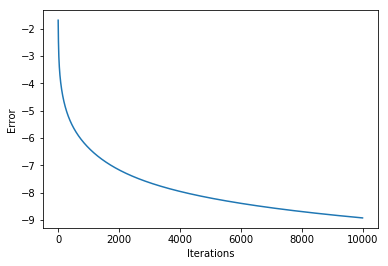

In [68]:
# Fit training set
test.fit(x, y, False)

In [52]:
print(test.theta)
print(len(np.where(test.theta == 0)[0]))

[[-0.02973493]
 [-0.02374564]
 [-0.14698618]
 ...
 [ 0.14032954]
 [ 0.13474991]
 [-0.31790366]]
342


In [53]:
# Load 2015 playoff data
playoff_data = pd.read_csv(os.path.join(curr_directory,'data_sets/2015_playoffs.csv'))

raw_playoff_results = np.array(list(playoff_data['PTS'] - playoff_data['PTS.1']))
raw_playoff_team_pairs = np.array(list(zip(playoff_data['Visitor/Neutral'], playoff_data['Home/Neutral'])))
raw_playoff_dates = np.array(list(playoff_data['Date']))

In [54]:
playoff_pairs = {}

for i in range(len(raw_playoff_team_pairs)): 
    team_1 = raw_playoff_team_pairs[i][0]
    team_2 = raw_playoff_team_pairs[i][1]
    if (team_1,team_2) in playoff_pairs.keys(): 
        # if results > 0 --> team A won --> +1
        # if results < 0 --> team B won --> -1
        if raw_playoff_results[i] > 0: 
            playoff_pairs[team_1,team_2] += 1
        else: 
            playoff_pairs[team_1,team_2] += -1
    elif (team_2,team_1) in playoff_pairs.keys():
        # if results > 0 --> team B won --> -1
        # if results < 0 --> team A won --> +1
        if raw_playoff_results[i] > 0: 
            playoff_pairs[team_2,team_1] += -1
        else: 
            playoff_pairs[team_2,team_1] += 1
    else: 
        if raw_playoff_results[i] > 0: 
            playoff_pairs[team_1,team_2] = 1
        else: 
            playoff_pairs[team_1,team_2] = -1
            
print(playoff_pairs)

{('WAS', 'TOR'): 4, ('NOP', 'GSW'): -4, ('MIL', 'CHI'): -2, ('DAL', 'HOU'): -3, ('BOS', 'CLE'): -4, ('BRK', 'ATL'): -2, ('POR', 'MEM'): -3, ('SAS', 'LAC'): -1, ('WAS', 'ATL'): -2, ('MEM', 'GSW'): -2, ('CHI', 'CLE'): -2, ('LAC', 'HOU'): -1, ('HOU', 'GSW'): -3, ('CLE', 'ATL'): 4, ('CLE', 'GSW'): -2}


In [55]:
playoff_teams = []
playoff_results = []
playoff_dates = []

for key in playoff_pairs: 
    playoff_teams.append([key[0], key[1]])
    playoff_results.append(playoff_pairs[key])
    playoff_dates.append('2015-04-10')
    
playoff_teams = np.array(playoff_teams)
playoff_results = np.array(playoff_results)
playoff_dates = np.array(playoff_dates)
    
playoff_x, playoff_y = test.process_data(playoff_teams, playoff_dates, playoff_results)

predicted_y = []
predictions = []
for i in range(playoff_x.shape[0]):
    x = playoff_x[i,:]
    x_new = np.reshape(x, (2*num_players + 1, 1))
    prediction = test.predict(x_new)
    predictions.append(prediction)
    if np.asscalar(prediction) > 0.5: 
        predicted_y.append(1)
    else: 
        predicted_y.append(0)
        
predicted_y = np.array(predicted_y)

In [56]:
print(predictions)
print(predicted_y)
print(playoff_y)

[array([[0.01651957]]), array([[0.00598489]]), array([[0.05309216]]), array([[0.27872793]]), array([[0.47266081]]), array([[0.17786811]]), array([[0.23678658]]), array([[0.46782058]]), array([[0.25878035]]), array([[0.03021057]]), array([[0.24370931]]), array([[0.60550504]]), array([[0.03704126]]), array([[0.90809273]]), array([[0.3214424]])]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]


In [62]:
test_x, test_y = test.process_data(unique_teams[2501:3000], unique_dates[2501:3000], unique_game_results[2501:3000])

In [64]:
predicted_y = []
predictions = []

for i in range(test_x.shape[0]):
    x = test_x[i,:]
    x_new = np.reshape(x, (2*num_players + 1, 1))
    prediction = test.predict(x_new)
    predictions.append(prediction)
    if np.asscalar(prediction) > 0.5: 
        predicted_y.append(1)
    else: 
        predicted_y.append(0)
        
predicted_y = np.array(predicted_y)

In [65]:
np.mean(predicted_y.T == test_y)

0.49998192778342254